In [1]:
import random, os, gc, pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

from otto_utils import *

In [2]:
def run_lgbm(train, test, conf):
    seed_everything(conf.params['seed'])
    
    features = conf.features
    cat_features = conf.cat_features
    num_features = len(features)

    oof_predictions = np.zeros(len(train))
    feature_importance_df = pd.DataFrame()
    
    gt_sessions_ind = np.array(train[train[f'{conf.target[:-3]}_session']==1].index)
    
    kfold = GroupKFold(n_splits = conf.n_folds)

    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[conf.target], train['session'])):
        print('\n'+'-'*50 + f'\nTraining fold {fold} with {num_features} features...\n')
        
        trn_ind_x = np.intersect1d(trn_ind, gt_sessions_ind, assume_unique=True)
        val_ind_x = np.intersect1d(val_ind, gt_sessions_ind, assume_unique=True)
        x_train_x, x_val_x = train[features].iloc[trn_ind_x], train[features].iloc[val_ind_x]
        y_train_x, y_val_x = train[conf.target].iloc[trn_ind_x], train[conf.target].iloc[val_ind_x]
        
        x_val = train[features].iloc[val_ind]
        y_val = train[conf.target].iloc[val_ind]
        
        lgb_train = lgb.Dataset(x_train_x, y_train_x, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val_x, y_val_x, categorical_feature = cat_features)
        
        model = lgb.train(
            params = conf.params,
            train_set = lgb_train,
            num_boost_round = conf.trees,
            valid_sets = [lgb_train, lgb_valid],
            categorical_feature = cat_features,
            callbacks=[
                log_evaluation(conf.verbose),
            ] if conf.params["boosting"]=="dart" else [
                log_evaluation(conf.verbose),
                early_stopping(conf.early,verbose=True)                
            ]
        )
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = model.feature_name()
        fold_importance_df["importance"] = model.feature_importance(importance_type='split')
        fold_importance_df["importance2"] = model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        val_pred = model.predict(x_val)
        oof_predictions[val_ind] = val_pred
        
        s = pd.DataFrame({'session': train['session'], 'aid': train['aid'], 'pred': -1})
        s.loc[val_ind,'pred']=val_pred
        s = s[s['pred']>-0.5].copy()
        s = s.sort_values(['session','pred'],ascending=[True,False])
        s = s.reset_index(drop=True)
        s['n'] = s.groupby('session').cumcount()
        s = s[s['n']<20][['session','aid']].copy()
        
        test_labels = pd.read_parquet('input/otto-validation/test_labels.parquet')
        test_labels = test_labels[test_labels['type']==conf.target[:-3]].copy()
        test_labels = test_labels[test_labels['session'].isin(set(s['session']))].copy()
        test_labels['num_gt'] = test_labels['ground_truth'].apply(len)
        test_labels['num_gt'] = np.where(test_labels['num_gt']>20,20,test_labels['num_gt'])
        denom = test_labels['num_gt'].sum()
        del test_labels['type'], test_labels['num_gt']
        test_labels = test_labels.explode('ground_truth')
        test_labels.columns = ['session','aid']
        nom = len(s.merge(test_labels, on=['session','aid'],how='inner'))

        if conf.predict_test:
            test_predictions += model.predict(test[features]) / conf.n_folds
        
        score = roc_auc_score(y_val, val_pred)
        print(f'\nFold {fold} CV score is {score:.4f}')
        print(f'\nFold {fold} recall is {nom/denom:.6f}')
        print(f"nom={nom}; denom={denom}")
        
        save_object(model, f"models/lgb_{conf.target[:-3]}_{conf.trees}_tr_{conf.params['num_leaves']}_lv_{conf.params['boosting']}_fold_{fold}_{score:.4f}_{nom/denom:.6f}.pkl")
        
        del x_train_x, x_val_x, y_train_x, y_val_x, x_val, y_val, lgb_train, lgb_valid, s, test_labels
        gc_clear()
        
    oof = pd.DataFrame({'session': train['session'], 'aid': train['aid'], 'pred': oof_predictions})
    
    score = roc_auc_score(train[conf.target], oof_predictions)
    print(f'\nOut of folds CV score is {score:.4f}')
    
    s = oof.copy()
    s = s.sort_values(['session','pred'],ascending=[True,False])
    s = s.reset_index(drop=True)
    s['n'] = s.groupby('session').cumcount()
    s = s[s['n']<20][['session','aid']].copy()

    test_labels = pd.read_parquet('input/otto-validation/test_labels.parquet')
    test_labels = test_labels[test_labels['type']==conf.target[:-3]].copy()
    test_labels['num_gt'] = test_labels['ground_truth'].apply(len)
    test_labels['num_gt'] = np.where(test_labels['num_gt']>20,20,test_labels['num_gt'])
    denom = test_labels['num_gt'].sum()
    del test_labels['type'], test_labels['num_gt']
    test_labels = test_labels.explode('ground_truth')
    test_labels.columns = ['session','aid']
    nom = len(s.merge(test_labels, on=['session','aid'],how='inner'))
    print(f'\nOut of folds recall is {nom/denom:.6f}')
    print(f"nom={nom}; denom={denom}")
    
    save_object(oof_predictions, f"models/lgb_oof_{conf.target[:-3]}.pkl")
    
    if conf.predict_test:
        sub = pd.DataFrame({'session': test['session'], 'aid': test['aid'], 'pred': test_predictions})
    else:
        sub = None
        
    del s, test_labels, oof_predictions
    gc_clear()
        
    display_importances(feature_importance_df)
    feature_importance_df.to_csv(
        f"models/fe_lgb_{conf.target[:-3]}_{nom/denom:.6f}.csv",
        index=False
    )
    return oof, sub
    

def display_importances(feature_importance_df_):
    tops = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:80].index
    tops2 = feature_importance_df_[["feature", "importance2"]].groupby("feature").mean().sort_values(by="importance2", ascending=False)[:80].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(tops)]
    best_features2 = feature_importance_df_.loc[feature_importance_df_.feature.isin(tops2)]
    
    plt.figure(figsize=(8, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features Split (avg over folds)')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 15))
    sns.barplot(x="importance2", y="feature", data=best_features2.sort_values(by="importance2", ascending=False))
    plt.title('LightGBM Features Gain (avg over folds)')
    plt.tight_layout()
    plt.show()

In [3]:
train = pd.concat(
    [
        pd.read_parquet("feats/feats_0_batch_0.pqt"),
        pd.read_parquet("feats/feats_0_batch_1.pqt"),
        pd.read_parquet("feats/feats_0_batch_2.pqt"),
        pd.read_parquet("feats/feats_0_batch_3.pqt"),
    ],
    ignore_index=True
)
train

,session,aid,matrices_num,matrices_numsum,matrices_wgt_rel_mean,CA_estimation_frCL_trn,CA_estimation_frCL_tst,OR_estimation_frCA_trn,OR_estimation_frCL_trn,a2s_actions_num,a2s_actions_rel,a2s_best_action_type,a2s_carts_num,a2s_carts_rel,a2s_clicks_num,a2s_clicks_rel,a2s_last_action_index,a2s_last_cart_index,a2s_last_click_index,a2s_orders_rel,aid_CA2OR_trn,aid_CA_rank_int_tst_vs_trn,aid_CA_vs_mean_trn,aid_CA_vs_mean_tst,aid_CA_vs_mean_tst_vs_trn,aid_CL2CA_trn,aid_CL2CA_tst,aid_CL2OR_trn,aid_CL_rank_int_trn,aid_CL_rank_int_tst_vs_trn,aid_CL_rank_pct_tst_vs_trn,aid_CL_vs_mean_trn,aid_CL_vs_mean_tst_vs_trn,aid_clicks_favourite_dow_diff_test,aid_multi_clicks_percent_full,aid_multi_orders_percent_train,carts_rating_full,carts_rating_train,clicks_rating_full,clicks_rating_train,orders_rating_full,session_actions,session_avg_real_items_num,session_avg_real_length,session_carts,session_carts_avg_hour,session_carts_avg_real,session_click_diff_mean,session_clicks,session_full_length,session_items,session_items_carted,session_items_clicked,ts_diff,ts_diff_carts,ts_diff_carts_rel,ts_diff_clicks,ts_diff_clicks_rel,ts_diff_orders,ts_diff_orders_rel,ts_diff_rel,v11m_indmin,v11m_num,v21k_num,v21m_indmin,v31m_indmin,v31m_num,v51ha_indmin,wgt_rel_v11m_mean,wgt_rel_v11m_sum,wgt_rel_v21k_mean,wgt_rel_v21k_sum,wgt_rel_v21m_mean,wgt_rel_v21m_sum,wgt_rel_v31m_mean,wgt_rel_v31m_sum,wgt_rel_v51ha_mean,wgt_rel_v51ha_sum,wgt_v11m_mean,wgt_v11m_sum,wgt_v21k_sum,wgt_v21m_mean,wgt_v21m_sum,wgt_v31m_mean,wgt_v31m_sum,wgt_v51ha_mean,wgt_v51ha_sum,emb_diff_sh1_1_pub,emb_angle_sh1_1_pub,emb_diff_sh2_1_pub,emb_angle_sh2_1_pub,emb_diff_w2v,emb_angle_w2v,emb_diff_w2v_100,emb_angle_w2v_100,clicks_gt,carts_gt,orders_gt,clicks_session,carts_session,orders_session
0,12629600,1673830,0,0,-5.000000,0.157303,0.041667,0.0,0.044944,1,1.0,0,0,-1.0,1,1.0,0,999,0,-1.0,0.285714,1.186586,2.370294,1.531400,0.646080,0.157303,0.041667,0.044944,180395.0,0.199983,0.417293,1.613197,2.392106,0,0.336283,0.250000,115578,112944,133953,149988,122705,1,1.0,0.0,0,-1.0,0.0,-1.0,1,0,1,0,1,0,1661646276,1.661646e+09,0,0.000000e+00,1661646276,1.661646e+09,0.000000e+00,-1,0,0,-1,-1,0,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0,0,1,0,0
1,12630000,1659103,5,5,1209.857239,0.150416,0.285714,0.0,0.041023,1,0.5,0,0,-1.0,1,0.5,1,999,1,-1.0,0.272727,1.054926,42.834606,21.439598,0.500520,0.150416,0.285714,0.041023,6443.0,2.403694,5.015638,30.487604,0.258422,3,0.314847,0.028986,4138,4263,5787,5615,6718,2,2.0,14.0,0,-1.0,0.0,14.0,2,14,2,0,2,14,1661647133,1.107765e+08,14,9.333333e-01,1661647133,1.107765e+08,9.333333e-01,1,1,1,0,1,1,0,0.018626,0.018626,0.025031,0.025031,0.036532,0.036532,0.017549,0.017549,0.070093,0.070093,144.0,144.0,241.0,421.0,421.0,358.857239,358.857239,45.0,45.0,2.852127,0.962233,0.506473,0.992621,7.174855,0.853740,4.375782,0.868151,0,0,0,1,0,0
2,12630000,1594331,5,5,1202.141388,0.121429,0.085714,0.0,0.038095,1,0.5,0,0,-1.0,1,0.5,0,999,0,-1.0,0.313725,0.643455,25.903932,18.376799,0.709421,0.121429,0.085714,0.038095,9677.5,0.385585,0.804576,22.838514,0.985636,0,0.315000,0.083333,8486,8808,7637,8108,10396,2,2.0,14.0,0,-1.0,0.0,14.0,2,14,2,0,2,0,1661647133,1.107765e+08,0,0.000000e+00,1661647133,1.107765e+08,0.000000e+00,0,1,1,0,0,1,0,0.016961,0.016961,0.021964,0.021964,0.029800,0.029800,0.018545,0.018545,0.046237,0.046237,144.0,144.0,240.0,415.0,415.0,360.141388,360.141388,43.0,43.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1,0,0,1,0,0
3,12630400,1431314,0,0,-5.000000,0.099217,0.181818,0.0,0.039164,1,1.0,0,0,-1.0,1,1.0,0,999,0,-1.0,0.394737,0.143889,6.433656,15.313999,2.380295,0.099217,0.181818,0.039164,43382.5,0.308408,0.643535,6.942183,1.273864,0,0.171233,0.133333,34648,41255,45081,49281,41272,1,1.0,0.0,0,-1.0,0.0,-1.0,1,0,1,0,1,0,1661648073,1.661648e+09,0,0.000000e+00,16

In [4]:
feats = []
catfeats = []
class CFG:
    def __init__(self):
        self.n_folds = 3
        self.trees = 1000
        self.early = 100
        self.verbose = 50
        self.params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting': 'gbdt',
            'seed': 42,
            'num_leaves': 16,
            'learning_rate': 0.05,
            'feature_fraction': 0.80,
            'n_jobs': -1,
            'lambda_l2': 2,
            'min_data_in_leaf': 50,
        }
        self.target = 'clicks_gt'
        self.features = feats
        self.cat_features = catfeats
        self.predict_test = False

In [5]:
out_dict = {
    'orders': [
        'a2s_actions_rel', 'a2s_best_action_type', 'a2s_actions_num', 'a2s_last_action_index', 'ts_diff',
        'a2s_carts_rel', 'a2s_last_click_index', 'a2s_last_cart_index', 'a2s_carts_num', 'wgt_v51ha_sum',
        'OR_estimation_frCA_trn', 'aid_CL2OR_trn', 'ts_diff_clicks', 'wgt_v21m_sum', 'session_actions',
        'session_carts', 'wgt_rel_v51ha_mean', 'wgt_v21k_sum', 'v51ha_indmin', 'wgt_rel_v51ha_sum',
        'wgt_rel_v21m_sum', 'wgt_v31m_sum', 'session_carts_avg_real', 'ts_diff_carts', 'ts_diff_orders_rel',
        'a2s_clicks_rel', 'OR_estimation_frCL_trn', 'session_clicks', 'carts_rating_full', 'ts_diff_clicks_rel',
        'session_carts_avg_hour', 'ts_diff_carts_rel', 'ts_diff_rel', 'wgt_rel_v31m_sum', 'wgt_rel_v21m_mean',
        'session_full_length', 'aid_CL2CA_tst', 'aid_CA2OR_trn', 'v21m_indmin', 'a2s_orders_rel',
        'session_items_carted', 'aid_CA_rank_int_tst_vs_trn', 'session_avg_real_length', 'ts_diff_orders',
        'carts_rating_train', 'v21k_num', 'wgt_v51ha_mean', 'orders_rating_full', 'aid_multi_orders_percent_train',
        'aid_multi_clicks_percent_full'
    ],
    'carts': [
        'a2s_last_action_index', 'ts_diff', 'a2s_actions_rel', 'ts_diff_rel', 'wgt_v51ha_sum', 'wgt_v21m_sum',
        'wgt_rel_v21m_sum', 'wgt_rel_v51ha_sum', 'session_clicks', 'wgt_v31m_sum', 'a2s_clicks_rel',
        'wgt_rel_v51ha_mean', 'wgt_v21k_sum', 'v51ha_indmin', 'session_items_clicked', 'wgt_rel_v31m_sum',
        'session_items', 'v21m_indmin', 'wgt_rel_v21k_sum', 'wgt_v11m_sum', 'a2s_last_click_index', 
        'wgt_rel_v21m_mean', 'aid_CL2CA_tst', 'ts_diff_carts_rel', 'CA_estimation_frCL_trn', 'aid_CL2CA_trn',
        'ts_diff_clicks_rel', 'clicks_rating_train', 'ts_diff_orders_rel', 'aid_CL_vs_mean_trn', 'ts_diff_clicks',
        'aid_CL_rank_int_tst_vs_trn', 'session_full_length', 'aid_multi_clicks_percent_full', 'wgt_v51ha_mean',
        'session_avg_real_items_num', 'a2s_actions_num', 'aid_CL_rank_int_trn', 'v31m_num', 'v31m_indmin',
        'a2s_clicks_num', 'CA_estimation_frCL_tst', 'wgt_rel_v21k_mean', 'aid_CL_vs_mean_tst_vs_trn',
        'aid_CL_rank_pct_tst_vs_trn', 'aid_CA_rank_int_tst_vs_trn', 'aid_CA_vs_mean_tst', 'clicks_rating_full',
        'session_click_diff_mean', 'aid_CA_vs_mean_tst_vs_trn'
    ],
    'clicks': [
        'a2s_last_action_index', 'a2s_actions_rel', 'ts_diff', 'session_actions', 'wgt_rel_v31m_mean', 
        'wgt_v31m_sum', 'wgt_rel_v11m_mean', 'v31m_indmin', 'wgt_rel_v31m_sum', 'wgt_v11m_sum', 'v11m_indmin',
        'session_items', 'session_clicks', 'session_full_length', 'wgt_v11m_mean', 'aid_CL_rank_int_tst_vs_trn',
        'wgt_v31m_mean', 'ts_diff_carts_rel', 'ts_diff_rel', 'aid_CL_vs_mean_tst_vs_trn', 'a2s_actions_num',
        'session_avg_real_items_num', 'v31m_num', 'ts_diff_orders_rel', 'ts_diff_clicks_rel', 
        'session_items_clicked', 'aid_multi_clicks_percent_full', 'aid_CL_rank_pct_tst_vs_trn', 'wgt_v51ha_sum',
        'aid_CL_vs_mean_trn', 'v21k_num', 'wgt_rel_v21k_sum', 'wgt_v21m_sum', 'carts_rating_train', 'wgt_v21m_mean', 
        'wgt_rel_v11m_sum', 'aid_CA_vs_mean_trn', 'ts_diff_clicks', 'wgt_v21k_sum', 'v11m_num', 
        'a2s_last_click_index', 'clicks_rating_full', 'wgt_rel_v21k_mean', 'clicks_rating_train', 
        'aid_clicks_favourite_dow_diff_test', 'a2s_carts_rel', 'wgt_rel_v21m_mean', 'wgt_v51ha_mean', 
        'wgt_rel_v51ha_mean', 'CA_estimation_frCL_trn'
    ]
}

In [6]:
pub_sh1_1 = ['emb_diff_sh1_1_pub','emb_angle_sh1_1_pub']
pub_sh2_1 = ['emb_diff_sh2_1_pub','emb_angle_sh2_1_pub']
w2v = ['emb_diff_w2v','emb_angle_w2v']

emb_feats = pub_sh1_1+pub_sh2_1+w2v


--------------------------------------------------
Training fold 0 with 59 features...

[LightGBM] [Info] Number of positive: 7323, number of negative: 876940
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11448
[LightGBM] [Info] Number of data points in the train set: 884263, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008281 -> initscore=-4.785418
[LightGBM] [Info] Start training from score -4.785418
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.938438	valid_1's auc: 0.934979
[100]	training's auc: 0.942065	valid_1's auc: 0.936228
[150]	training's auc: 0.944653	valid_1's auc: 0.936593
[200]	training's auc: 0.946705	valid_1's auc: 0.936771
[250]	training's auc: 0.948888	valid_1's auc: 0.936916
[300]	training's auc: 0.95079	valid_1's auc: 0.937016
[350]	training's auc: 

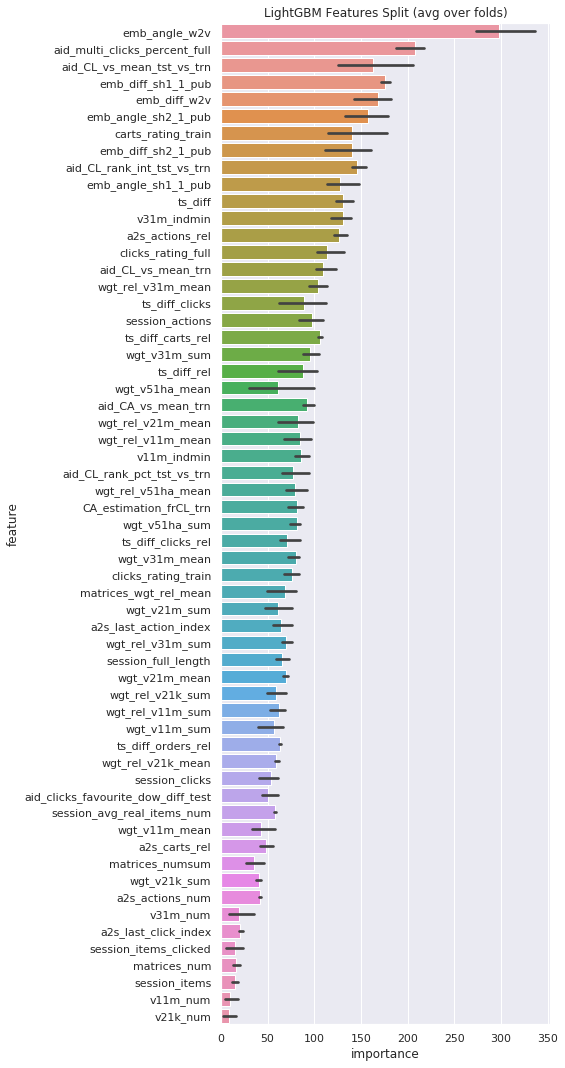

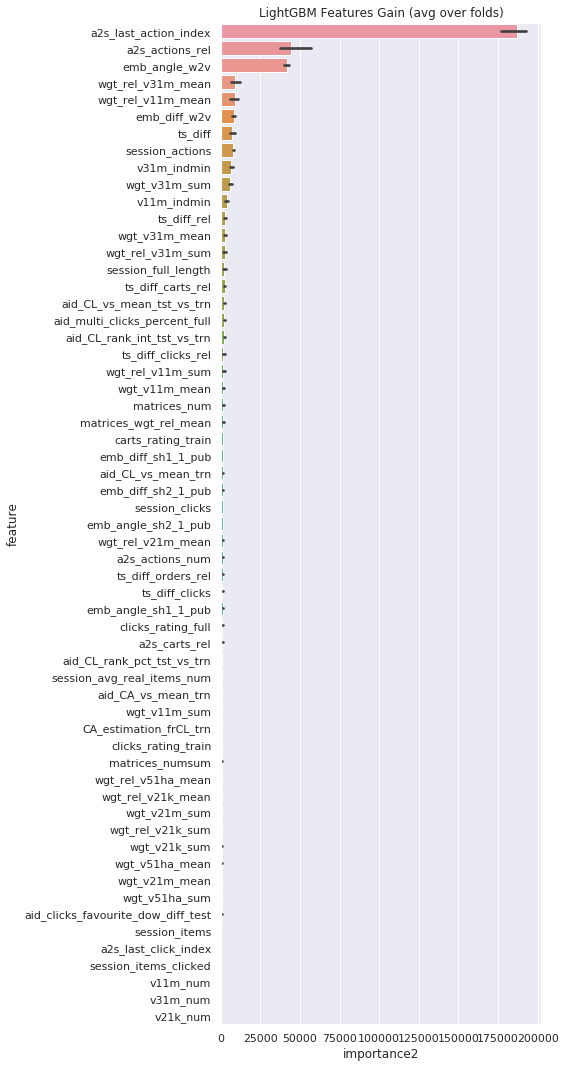

In [7]:
C1 = CFG()
C1.trees = 2000
C1.params['seed'] = 42
C1.params['learning_rate'] = 0.05
C1.params['min_data_in_leaf'] = 20
C1.features = out_dict['clicks'] + [
    'matrices_num','matrices_numsum','matrices_wgt_rel_mean'
] + emb_feats
C1.cat_features = ['a2s_best_action_type'] if ('a2s_best_action_type' in C1.features) else []
C1.target = 'clicks_gt'

clicks_oof, _ = run_lgbm(train, None, C1)